# Technical validation

This notebook contains all the code for the technical analysis of the dataset.
See the technical analysis section in the paper for details.

It is possible to reproduce the whole section except for the overview plot of
the recording that has been filtered from the dataset.

In [3]:
import glob
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal, stats
from tqdm import tqdm

MOVEMENT_LIST = [
    "Rest",
    "MassFlexion",
    "HookGrasp",
    "ThumbAdduction",
    "PinchGrasp",
    "PinchGraspMiddle",
    "PinchGraspRing",
    "PinchGraspPinkie",
    "DiameterGrasp",
    "SphereGrasp",
    "MassAdduction",
    "MassExtension",
    "WristVolarFlexion",
    "WristDorsiFlexion",
    "ForearmPronation",
    "ForearmSupination",
]

MOVEMENT_COLORS = dict(zip(MOVEMENT_LIST, plt.cm.rainbow(np.linspace(0, 1, len(MOVEMENT_LIST)))))
DATA_DIR = Path(os.getenv("PHYSIOMIO_DATA_DIR", "data"))

all_parquet_files = glob.glob(str(DATA_DIR / "**/*.parquet"), recursive=True)
assert len(all_parquet_files) > 0, "No parquet files found under data"
print(f"Found {len(all_parquet_files)} parquet files under {DATA_DIR}")

Found 329 parquet files under data


# Overview plots

We provide functions to generate an overview plot for a single recording, which
highlights all movements in all channels for a recording, and calculates per
channel and per file pooled SNR statistics (mean and standard deviation).

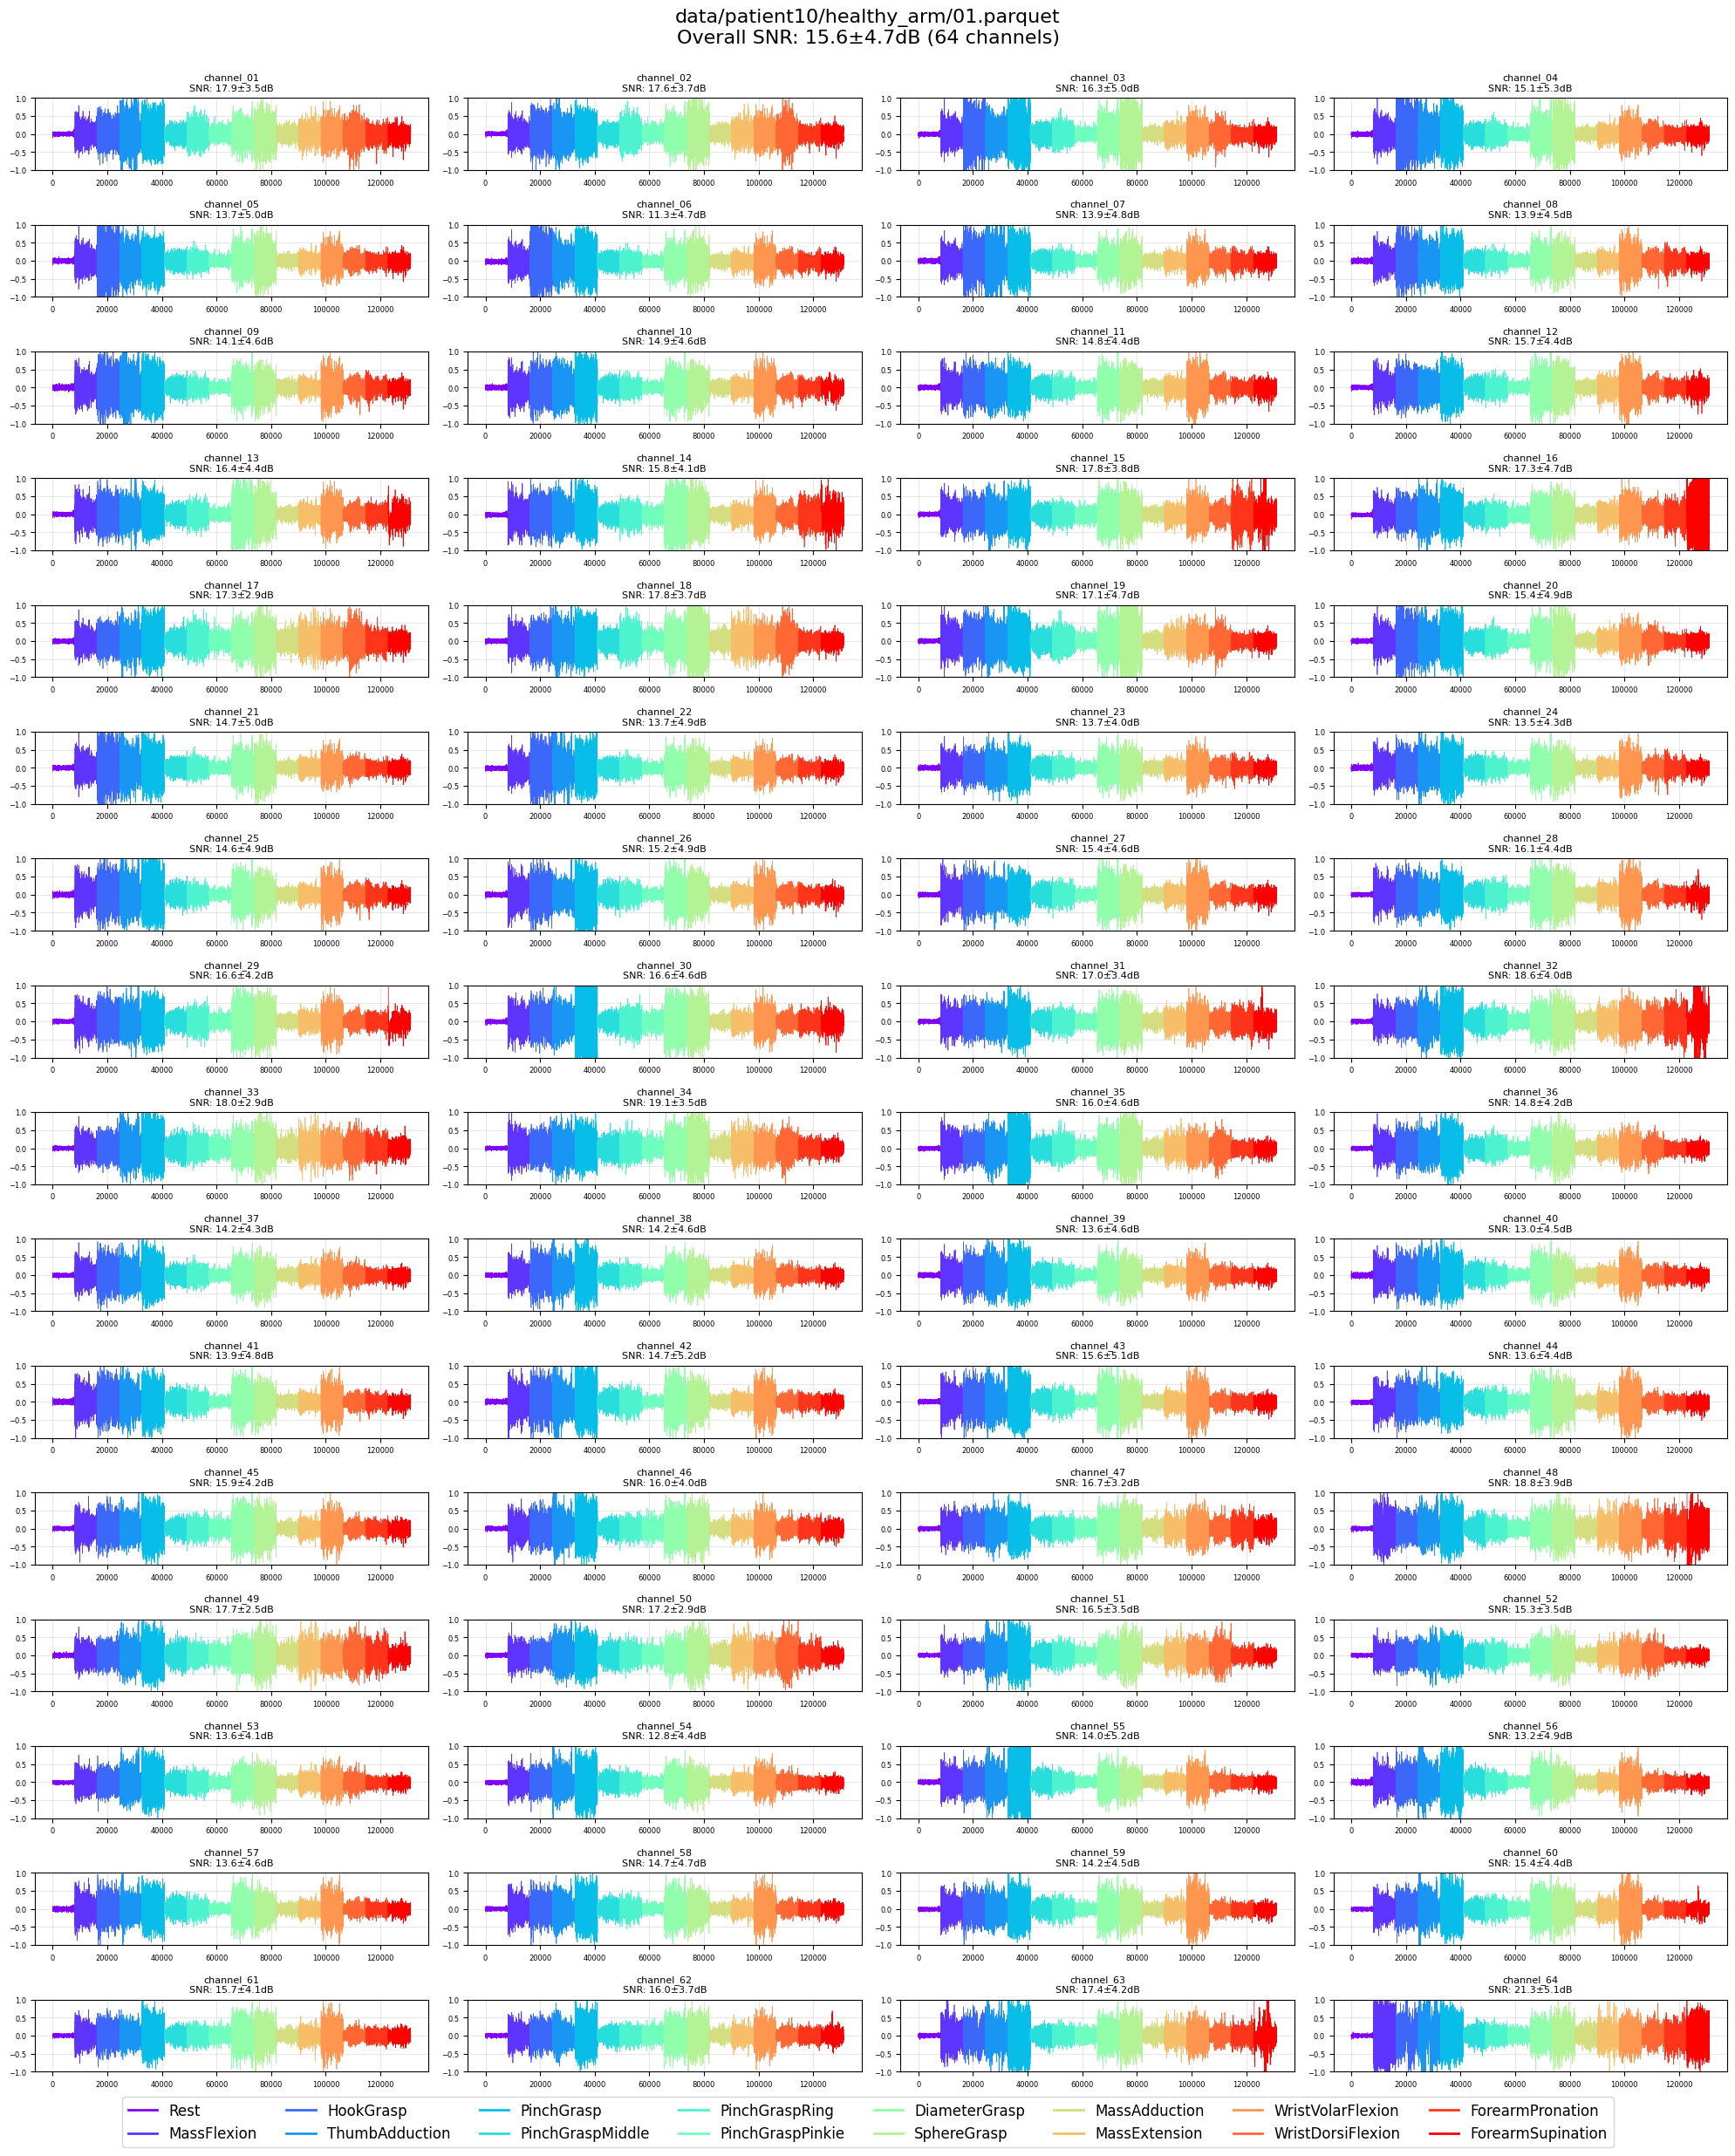

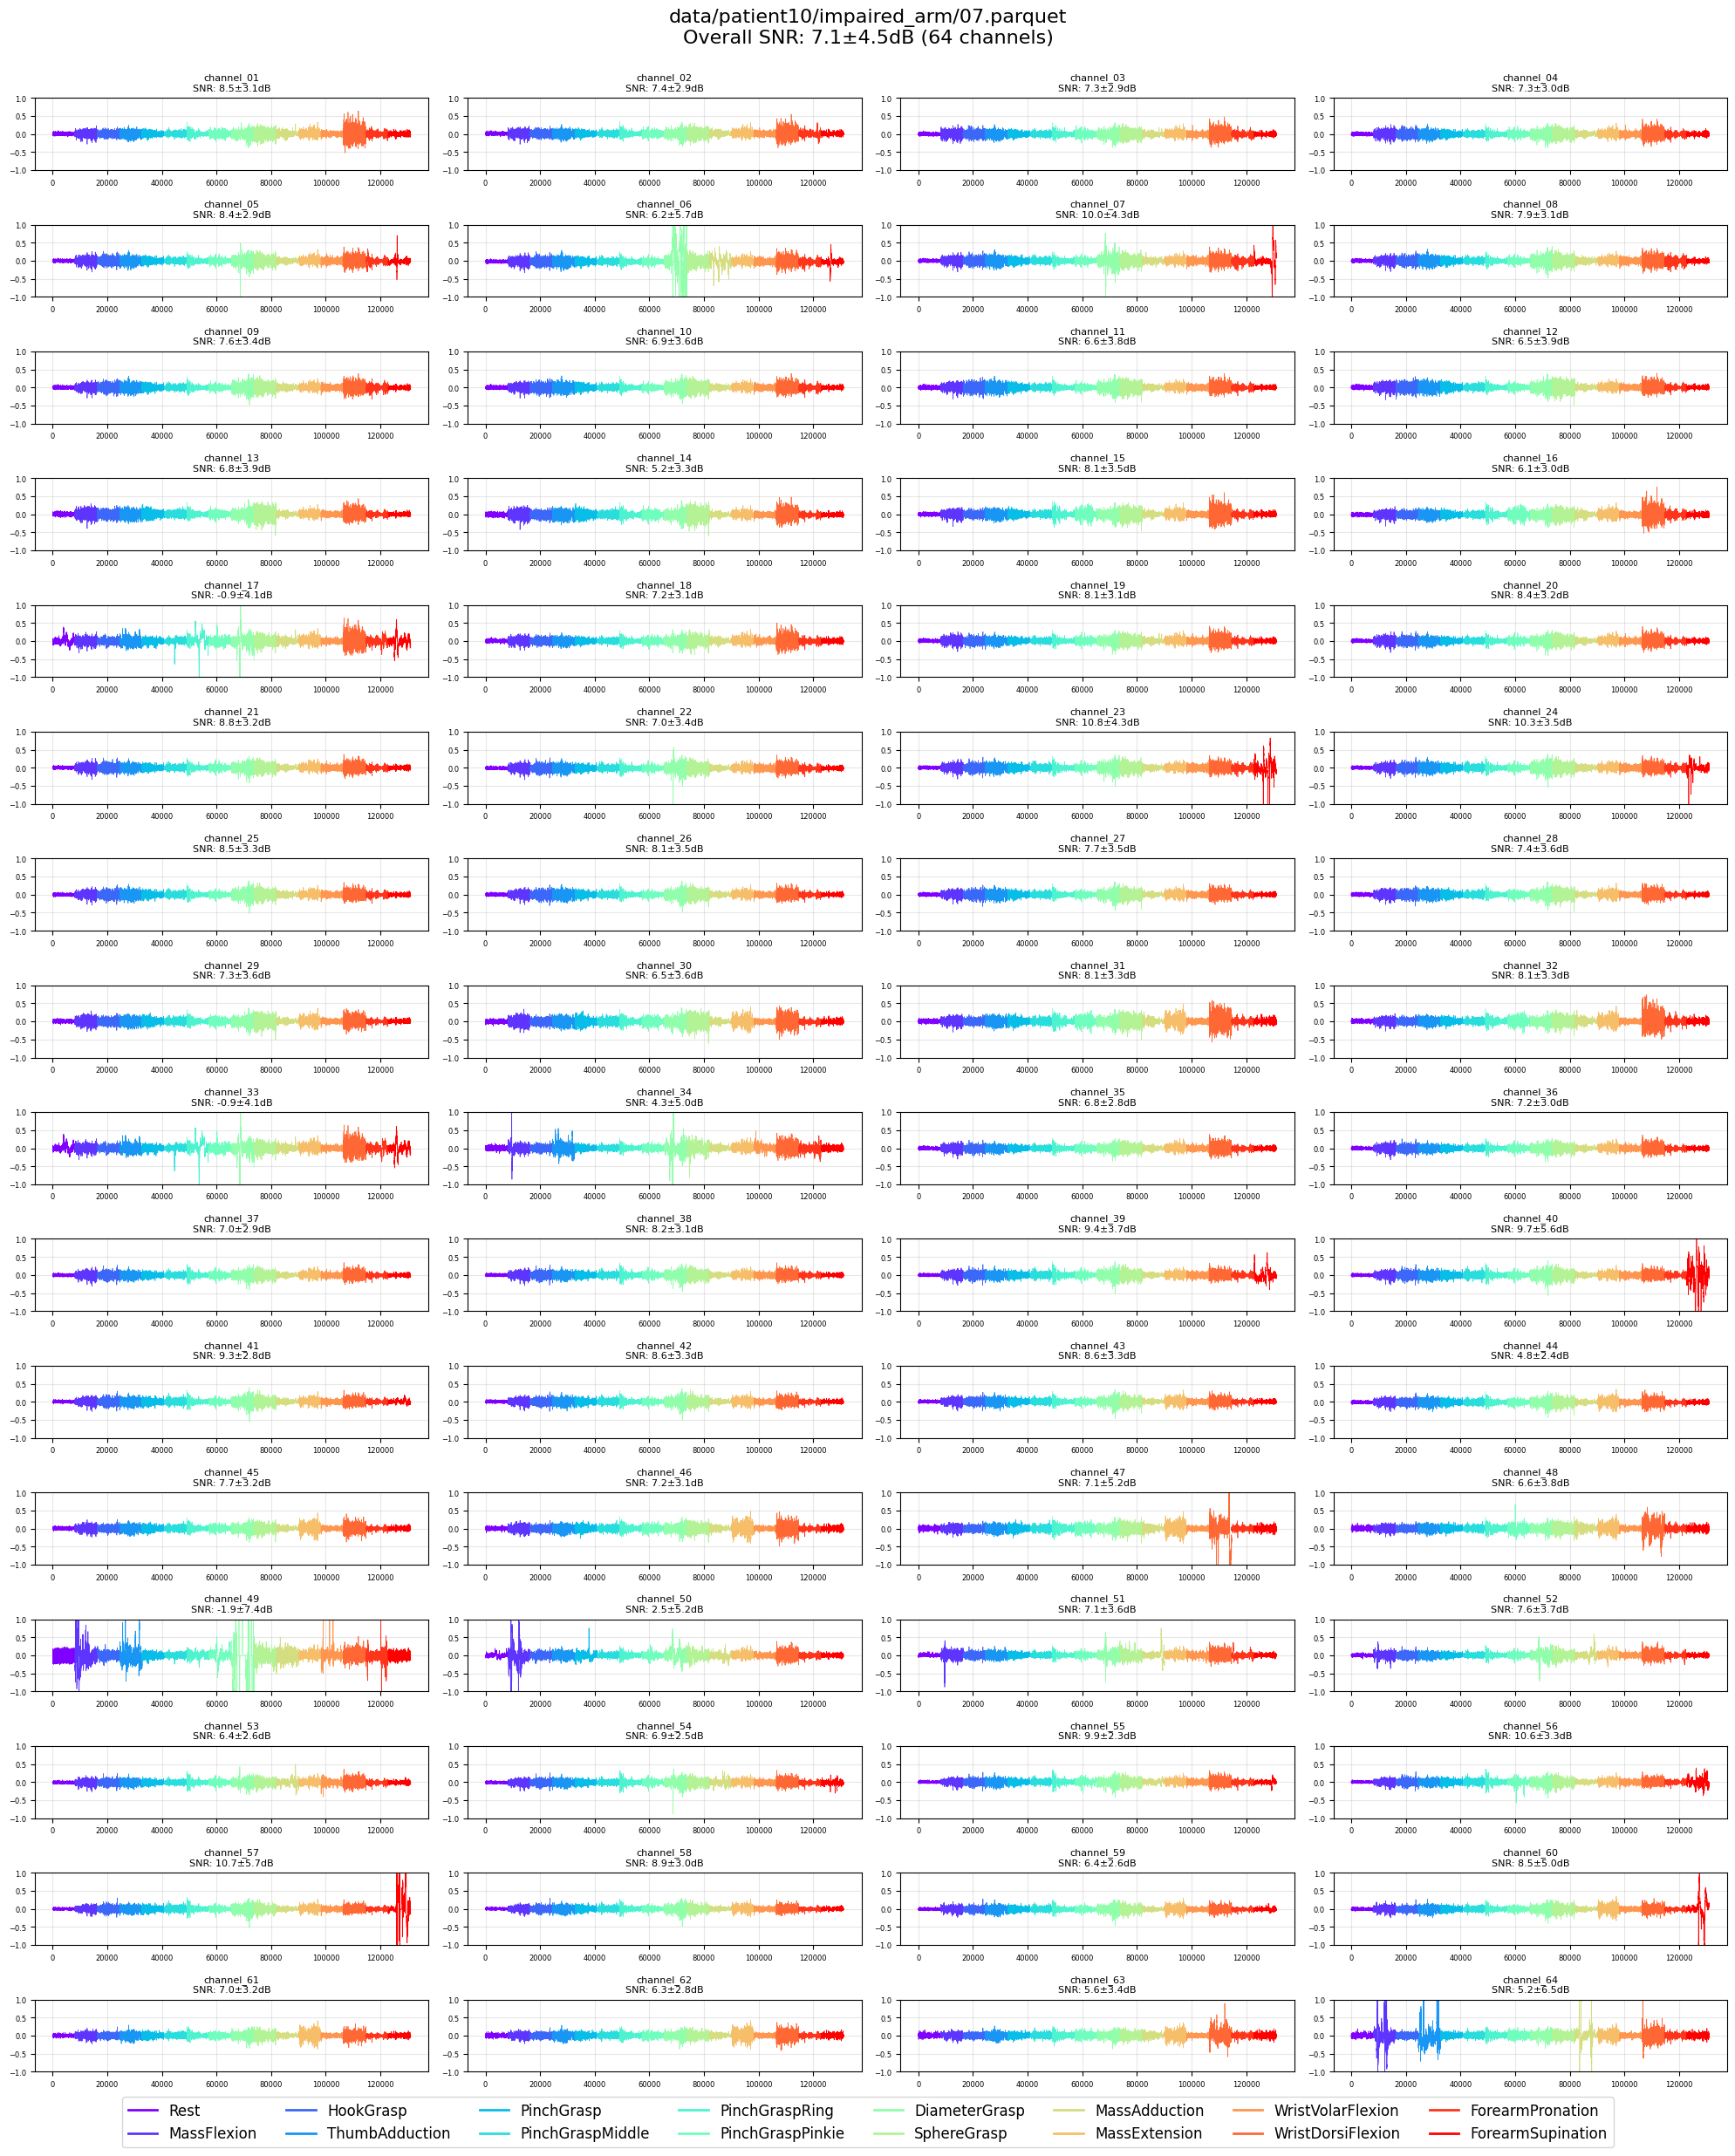

In [16]:
def calculate_channel_mean_amplitude(
        df: pd.DataFrame,
        channel: str,
        movement_type_col: str = 'movement_type') -> tuple[dict[str, float], float, float]:
    """
    Calculate SNR statistics for a single channel using mean amplitude.

    Args:
        df: DataFrame containing the EMG data and movement labels
        channel: Name of the channel column to analyze
        movement_type_col: Name of the column containing movement labels

    Returns:
        tuple containing:
            - Dictionary mapping movement names to SNR values
            - Mean SNR across all movements (excluding Rest)
            - Standard deviation of SNR across movements
    """
    unique_movements = df[movement_type_col].unique()
    mean_amps = {}
    snr_values = {}

    # Calculate Rest mean amplitude first
    rest_mask = df[movement_type_col] == 'Rest'
    assert 'Rest' in unique_movements, "Rest movement must be present in the data"

    rest_ma = df.loc[rest_mask, channel].abs().mean()
    mean_amps['Rest'] = rest_ma

    # Calculate other mean amplitudes and SNR
    for movement in unique_movements:
        if movement == 'Rest':
            continue
        mask = df[movement_type_col] == movement
        ma = df.loc[mask, channel].abs().mean()
        mean_amps[movement] = ma
        # Using 20*log10 for amplitude ratio
        snr_values[movement] = 20 * np.log10(ma / rest_ma)

    # Calculate average SNR and std dev
    snr_values_list = list(snr_values.values())
    avg_snr = float(np.mean(snr_values_list))
    std_snr = float(np.std(snr_values_list))

    return snr_values, avg_snr, std_snr


def plot_channel_for_subplot(ax: plt.Axes, df: pd.DataFrame, channel: str,
                             snr_calculator, movement_type_col: str = 'movement_type',
                             y_axis_limits: tuple[float, float] | None = None) -> plt.Axes:
    """
    Colorize movements for a channel in a way that works with subplot axes

    Args:
        ax: Matplotlib axes to plot on
        df: DataFrame containing the EMG data and movement labels
        channel: Name of the channel column to plot
        snr_calculator: Function to calculate SNR statistics
        movement_type_col: Name of the column containing movement labels
        y_axis_limits: Optional tuple of (ymin, ymax) to set axis limits

    Returns:
        The modified matplotlib axes
    """
    # Calculate SNR statistics
    _, avg_snr, std_snr = snr_calculator(df, channel, movement_type_col)

    # Plot channel values colored by movement type on the given axis
    unique_movements = df[movement_type_col].unique()
    for movement in unique_movements:
        mask = df[movement_type_col] == movement
        data = df.loc[mask, channel]
        ax.plot(df.index[mask], data,
                color=MOVEMENT_COLORS[movement], linewidth=0.5)

    # Set title with SNR if available
    if avg_snr is not None and std_snr is not None:
        ax.set_title(
            f'{channel}\nSNR: {avg_snr:.1f}±{std_snr:.1f}dB', fontsize=8)
    else:
        ax.set_title(f'{channel}', fontsize=8)

    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=6)

    # Set y-axis limits if provided
    if y_axis_limits is not None and len(y_axis_limits) == 2:
        ax.set_ylim(y_axis_limits[0], y_axis_limits[1])

    return ax


def calculate_overall_snr(df: pd.DataFrame, snr_calculator,
                          movement_type_col: str = 'movement_type') -> tuple[float, float, list[float]]:
    """
    Calculate overall SNR across all channels

    Args:
        df: DataFrame containing the EMG data and movement labels
        snr_calculator: Function to calculate SNR statistics
        movement_type_col: Name of the column containing movement labels

    Returns:
        tuple containing:
            - Mean SNR across all channels and movements
            - Standard deviation of SNR across all channels and movements
            - List of all individual SNR values
    """
    all_snr_values = []

    for i in range(64):
        channel_name = f'channel_{i+1:02d}'
        if channel_name in df.columns:
            # Calculate SNR for this channel
            snr_values, _, _ = snr_calculator(
                df, channel_name, movement_type_col)
            # Add all individual SNR values for this channel
            all_snr_values.extend(list(snr_values.values()))

    overall_mean_snr = float(np.mean(all_snr_values))
    overall_std_snr = float(np.std(all_snr_values))
    return overall_mean_snr, overall_std_snr, all_snr_values


def plot_all_for_file(file_path: str | Path,
                      snr_calculator = calculate_channel_mean_amplitude,
                      movement_type_col: str = 'movement_type',
                      y_axis_limits: tuple[float, float] | None = None) -> None:
    """
    Plot all 64 channels in a 16x4 arrangement

    Args:
        file_path: Path to the parquet file containing EMG data
        snr_calculator: Function to calculate SNR statistics
        movement_type_col: Name of the column containing movement labels
        y_axis_limits: Optional tuple of (ymin, ymax) to set axis limits for all subplots
    """
    # Read the parquet file
    df = pd.read_parquet(file_path)

    # Create 16x4 subplot arrangement
    fig, axes = plt.subplots(16, 4, figsize=(20, 24))

    # Get unique movements and verify Rest is present
    unique_movements = df[movement_type_col].unique()
    assert 'Rest' in unique_movements, "Rest movement type is required"

    overall_mean_snr, overall_std_snr, _ = calculate_overall_snr(
        df, snr_calculator, movement_type_col)
    title_text = f'{file_path}\nOverall SNR: {overall_mean_snr:.1f}±{overall_std_snr:.1f}dB (64 channels)'

    fig.suptitle(title_text, fontsize=16, y=1.0)
    # Increased bottom margin for legend
    plt.subplots_adjust(top=0.95, bottom=0.15)

    # Plot each channel
    for i in range(64):
        row = i // 4
        col = i % 4
        channel_name = f'channel_{i+1:02d}'

        assert channel_name in df.columns, f"Channel {channel_name} not found in dataframe"
        plot_channel_for_subplot(axes[row, col], df, channel_name,
                                 snr_calculator, movement_type_col, y_axis_limits=y_axis_limits)

    # Add a legend using the first subplot that has data
    if len(unique_movements) > 0:
        # Create legend handles
        legend_handles = []
        for movement in unique_movements:
            handle = plt.Line2D([0], [0], color=MOVEMENT_COLORS[movement],
                                linewidth=2, label=movement)
            legend_handles.append(handle)

        # Calculate number of columns for legend (roughly half of unique movements)
        ncols = (len(unique_movements) + 1) // 2

        fig.legend(handles=legend_handles,
                   loc='center',
                   bbox_to_anchor=(0.5, -0.01),
                   ncol=ncols,
                   fontsize=12)

    plt.tight_layout()
    plt.show()


# Example: Plot the examples from the paper using mean amplitude
plot_all_for_file(
    Path(DATA_DIR) / "patient10" / "healthy_arm" / "01.parquet",
    snr_calculator=calculate_channel_mean_amplitude,
    y_axis_limits=(-1, 1))

plot_all_for_file(
    Path(DATA_DIR) / "patient10" / "impaired_arm" / "07.parquet",
    snr_calculator=calculate_channel_mean_amplitude,
    y_axis_limits=(-1, 1))

# Overall SNR

We calculate overall SNR statistic by calculating pooled mean and standard deviation
for each patients, separatedly for the healthy and the impaired side, and then
calculate the mean and standard deviation of the statistics generated in the
first step (non-pooled).

In [17]:
def get_patient_snrs_df(parquet_files: list[str]):
    """
    Calculate SNR statistics for healthy and impaired arms across patients.

    Args:
        parquet_files: List of paths to parquet files containing EMG data

    Returns:
        pd.DataFrame: Summary statistics with SNR means and standard deviations
                     for healthy and impaired arms per patient
    """
    rows = []
    all_healthy_values = []
    all_impaired_values = []

    # Group files by patient
    patients = {}
    for file in parquet_files:
        patient_num = int(file.split('/patient')[1].split('/')[0])
        if patient_num not in patients:
            patients[patient_num] = []
        patients[patient_num].append(file)

    # Calculate per-patient statistics
    patient_healthy_means = []
    patient_healthy_stds = []
    patient_impaired_means = []
    patient_impaired_stds = []

    for patient, files in tqdm(sorted(patients.items()), desc="Processing patients"):
        healthy_snrs = []
        impaired_snrs = []

        for file in tqdm(files, desc=f"Processing files for patient {patient}", leave=False):
            df = pd.read_parquet(file)
            _, _, snr = calculate_overall_snr(
                df, snr_calculator=calculate_channel_mean_amplitude)

            if 'healthy_arm' in file:
                healthy_snrs.append(snr)
            elif 'impaired_arm' in file:
                impaired_snrs.append(snr)

        healthy_flat = np.concatenate(healthy_snrs) if healthy_snrs else []
        impaired_flat = np.concatenate(impaired_snrs) if impaired_snrs else []

        if len(healthy_flat) > 0:
            all_healthy_values.extend(healthy_flat)
            patient_healthy_means.append(np.mean(healthy_flat))
            patient_healthy_stds.append(np.std(healthy_flat))
        if len(impaired_flat) > 0:
            all_impaired_values.extend(impaired_flat)
            patient_impaired_means.append(np.mean(impaired_flat))
            patient_impaired_stds.append(np.std(impaired_flat))

        rows.append({
            'Patient': f'Patient {patient}',
            'Healthy Arm SNR': f"{np.mean(healthy_flat):.2f}±{np.std(healthy_flat):.2f}" if len(healthy_flat) > 0 else "N/A",
            'Impaired Arm SNR': f"{np.mean(impaired_flat):.2f}±{np.std(impaired_flat):.2f}" if len(impaired_flat) > 0 else "N/A"
        })

    # Calculate mean across patients (using per-patient means and stds)
    rows.append({
        'Patient': 'Mean across patients',
        'Healthy Arm SNR': f"{np.mean(patient_healthy_means):.2f}±{np.mean(patient_healthy_stds):.2f}",
        'Impaired Arm SNR': f"{np.mean(patient_impaired_means):.2f}±{np.mean(patient_impaired_stds):.2f}"
    })

    # Calculate pooled statistics (using all values)
    rows.append({
        'Patient': 'Average (pooled observations)',
        'Healthy Arm SNR': f"{np.mean(all_healthy_values):.2f}±{np.std(all_healthy_values):.2f}",
        'Impaired Arm SNR': f"{np.mean(all_impaired_values):.2f}±{np.std(all_impaired_values):.2f}"
    })

    df_summary = pd.DataFrame(rows)
    return df_summary.style.set_properties(**{'text-align': 'center'}).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': '', 'props': [('border', '1px solid black')]},
        {'selector': 'th,td', 'props': [('padding', '8px')]}
    ])


# Calculate and display SNR summary statistics
display(get_patient_snrs_df(all_parquet_files))

Processing patients: 100%|██████████| 48/48 [21:25<00:00, 26.79s/it]


,Patient,Healthy Arm SNR,Impaired Arm SNR
0,Patient 1,17.86±6.96,11.79±5.81
1,Patient 2,15.93±6.31,6.69±5.70
2,Patient 3,21.01±6.04,12.14±5.73
3,Patient 4,16.22±5.15,12.14±5.42
4,Patient 5,21.02±7.02,11.74±3.74
5,Patient 6,10.69±4.05,8.54±4.26
6,Patient 7,10.72±4.86,7.43±4.56
7,Patient 8,14.25±4.03,11.07±4.39
8,Patient 9,18.43±8.62,12.19±5.77
9,Patient 10,14.62±4.51,11.19±4.67


# Correlation coefficient of Normality (CCN)

We also examine the distribution of amplitudes. We assess whether EMG
amplitudes follow the expected quasi-Gaussian distribution for steady
contractions. To this end we calculate the Correlation Coefficient of
Normality (CCN), defined as the Pearson correlation between the histogram
of EMG signal amplitudes and a normal distribution with the same mean
and variance.

A CCN close to 1 indicates the signal’s amplitude distribution is near-
Gaussian (as clean EMG should be). We calculate the CCN across the dataset, when
generate pooled summary statistics over all recordings, separated by recordings
of healthy and paretic arms:

In [11]:
def calculate_ccn(data: np.ndarray) -> float:
    hist, bin_edges = np.histogram(data, bins='auto', density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    mean = np.mean(data)
    std = np.std(data)
    normal_pdf = stats.norm.pdf(bin_centers, mean, std)

    return np.corrcoef(hist, normal_pdf)[0, 1]


results: list[dict] = []
healthy_ccns: list[float] = []
impaired_ccns: list[float] = []

for file in tqdm(all_parquet_files, desc="Calculating CCNs"):
    temp_df = pd.read_parquet(file)
    emg_cols = [col for col in temp_df.columns if col.startswith('channel_')]

    if not emg_cols:
        print(f"No EMG channels found in {file}")
        continue

    channel_ccns: dict[str, float] = {}
    for channel in emg_cols:
        signal = temp_df[channel].values
        ccn = calculate_ccn(signal)
        channel_ccns[channel] = ccn

        if 'healthy_arm' in file:
            healthy_ccns.append(ccn)
        elif 'impaired_arm' in file:
            impaired_ccns.append(ccn)

    avg_ccn = np.mean(list(channel_ccns.values()))
    results.append({
        'file': file,
        'avg_ccn': avg_ccn,
        'channel_ccns': channel_ccns,
        'arm_type': 'healthy' if 'healthy_arm' in file else 'impaired'
    })

file_summary_df = pd.DataFrame([{
    'file': r['file'],
    'avg_ccn': r['avg_ccn'],
    'arm_type': r['arm_type']
} for r in results])

healthy_channel_ccns: list[float] = []
impaired_channel_ccns: list[float] = []
for result in results:
    if result['arm_type'] == 'healthy':
        healthy_channel_ccns.extend(list(result['channel_ccns'].values()))
    else:
        impaired_channel_ccns.extend(list(result['channel_ccns'].values()))

healthy_mean = np.mean(healthy_channel_ccns)
healthy_std = np.std(healthy_channel_ccns)
impaired_mean = np.mean(impaired_channel_ccns)
impaired_std = np.std(impaired_channel_ccns)

summary_data = {
    'Arm Type': ['Healthy', 'Impaired'],
    'Mean CCN': [round(healthy_mean, 3), round(impaired_mean, 3)],
    'Std Dev': [round(healthy_std, 3), round(impaired_std, 3)]
}
summary_df = pd.DataFrame(summary_data)

display(summary_df)

Calculating CCNs: 100%|██████████| 329/329 [00:59<00:00,  5.50it/s]


,Arm Type,Mean CCN,Std Dev
0,Healthy,0.896,0.087
1,Impaired,0.904,0.079


# Spectral analysis

We examine the frequency content of EMG signals by computing power spectral
density (PSD). First, we apply a fourth-order high-pass filter at 20Hz to
attenuate motion artifacts and a second-order notch-filter at 50Hz to attenuate
the power line. We then use Welch’s method with a window size of 1024 to estimate
the power spectrum.

Processing files: 100%|██████████| 329/329 [02:35<00:00,  2.11it/s]


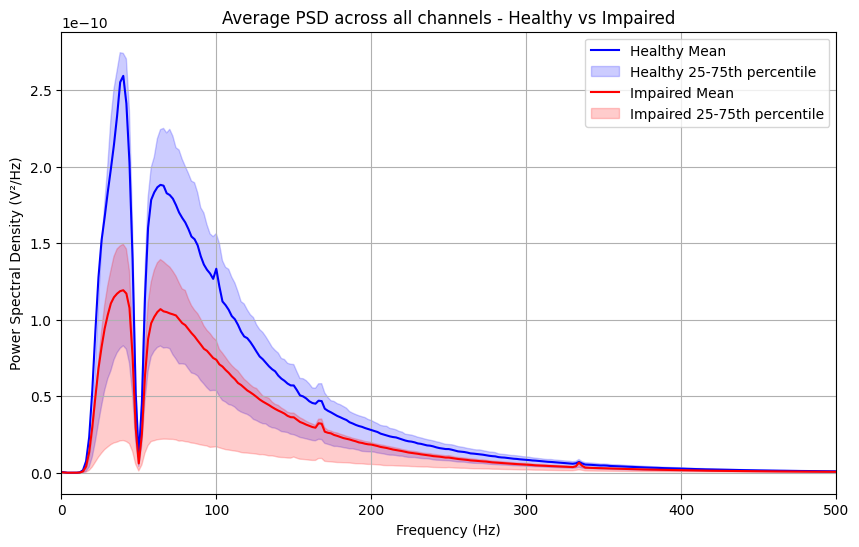

In [9]:
from scipy import signal

def preprocess_emg(data: np.ndarray, fs: float) -> np.ndarray:
    notch_freq = 50.0
    quality_factor = 10.0
    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, fs)
    filtered_data = signal.filtfilt(b_notch, a_notch, data)

    high_pass_freq = 20.0
    b_high, a_high = signal.butter(4, high_pass_freq/(fs/2), btype='high')
    filtered_data = signal.filtfilt(b_high, a_high, filtered_data)

    return filtered_data


def compute_psd(data: np.ndarray, fs: float, nperseg: int = 1024) -> tuple[np.ndarray, np.ndarray]:
    nperseg = min(nperseg, len(data) // 2)
    if nperseg < 256:
        nperseg = 256

    f, Pxx = signal.welch(data, fs, nperseg=nperseg, scaling="density")
    return f, Pxx


healthy_psds: list[np.ndarray] = []
impaired_psds: list[np.ndarray] = []
fs = 2048

for file in tqdm(all_parquet_files, desc="Processing files"):
    df = pd.read_parquet(file)
    is_healthy = 'healthy_arm' in file

    for channel in df.columns:
        if channel.startswith('channel_') and channel != 'channel_49':
            channel_data = df[channel].values * 0.001
            processed_emg = preprocess_emg(channel_data, fs)
            f, Pxx = compute_psd(processed_emg, fs, nperseg=1024)

            if is_healthy:
                healthy_psds.append(Pxx)
            else:
                impaired_psds.append(Pxx)

healthy_psds_array = np.array(healthy_psds)
impaired_psds_array = np.array(impaired_psds)

healthy_avg = np.mean(healthy_psds_array, axis=0)
healthy_25 = np.percentile(healthy_psds_array, 25, axis=0)
healthy_75 = np.percentile(healthy_psds_array, 75, axis=0)

impaired_avg = np.mean(impaired_psds_array, axis=0)
impaired_25 = np.percentile(impaired_psds_array, 25, axis=0)
impaired_75 = np.percentile(impaired_psds_array, 75, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(f, healthy_avg, 'b-', label='Healthy Mean')
plt.fill_between(f, healthy_25, healthy_75, color='b',
                 alpha=0.2, label='Healthy 25-75th percentile')
plt.plot(f, impaired_avg, 'r-', label='Impaired Mean')
plt.fill_between(f, impaired_25, impaired_75, color='r',
                 alpha=0.2, label='Impaired 25-75th percentile')

plt.xlabel('Frequency (Hz)')
plt.xlim(0, 500)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.ylabel('Power Spectral Density (V²/Hz)')
plt.title('Average PSD across all channels - Healthy vs Impaired')
plt.grid(True)
plt.legend()
plt.show()